In [ ]:
#@title NDVI Time Series Forecasting

In [ ]:
# Install required libraries
!pip install pmdarima statsmodels pandas numpy scikit-learn tensorflow matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.7 MB/s eta 0:00:00


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

In [ ]:
#@title Data Loading
def load_and_preprocess_data(file_path):
    # Load the data
    df = pd.read_csv(file_path, sep=',')

    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Sort by date
    df = df.sort_values('date')

    # Group by date and take mean NDVI (in case of multiple entries)
    df = df.groupby('date')['NDVI'].mean().reset_index()

    # Set date as index
    df.set_index('date', inplace=True)

    return df

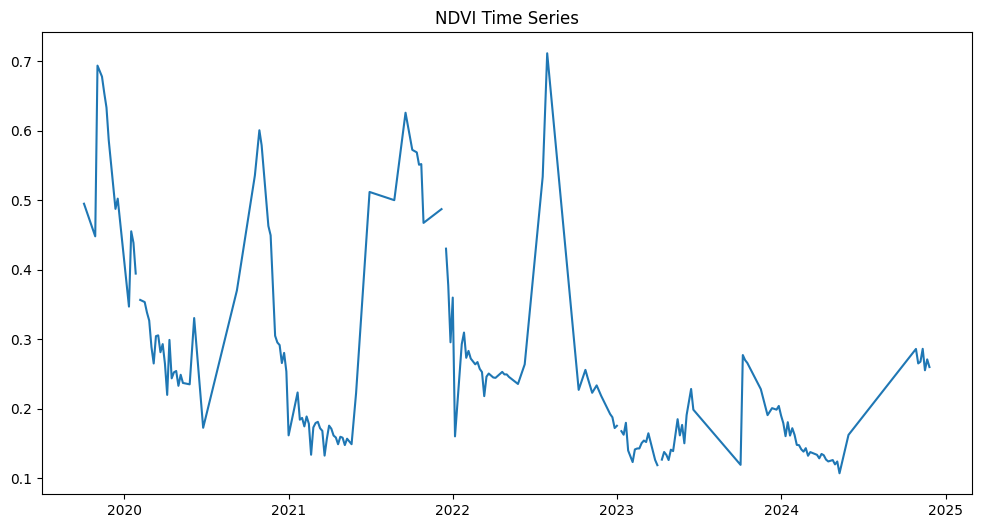

In [ ]:
 # Load data
data = load_and_preprocess_data(r'/content/BheemaHostel_NDVI_TimeSeries_2019_2024.csv')

# Visualize data
plt.figure(figsize=(12,6))
plt.plot(data.index, data['NDVI'])
plt.title('NDVI Time Series')
plt.show()


In [ ]:
data.head()

,NDVI
date,
2019-10-04,0.494896
2019-10-29,0.447936
2019-11-03,0.693659
2019-11-13,0.677842
2019-11-18,0.654514


In [ ]:
# @title Data interpolation
def loading_and_interpolation(file_path):
    # Load the data
    df = pd.read_csv(file_path, sep=',')

    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Sort by date
    df = df.sort_values('date')

    # Group by date and take mean NDVI (in case of multiple entries)
    df = df.groupby('date')['NDVI'].mean().reset_index()

    # Interpolate missing NDVI values based on the date index
    df['NDVI'] = df['NDVI'].interpolate(method='linear')

    # Set date as index
    df.set_index('date', inplace=True)

    return df

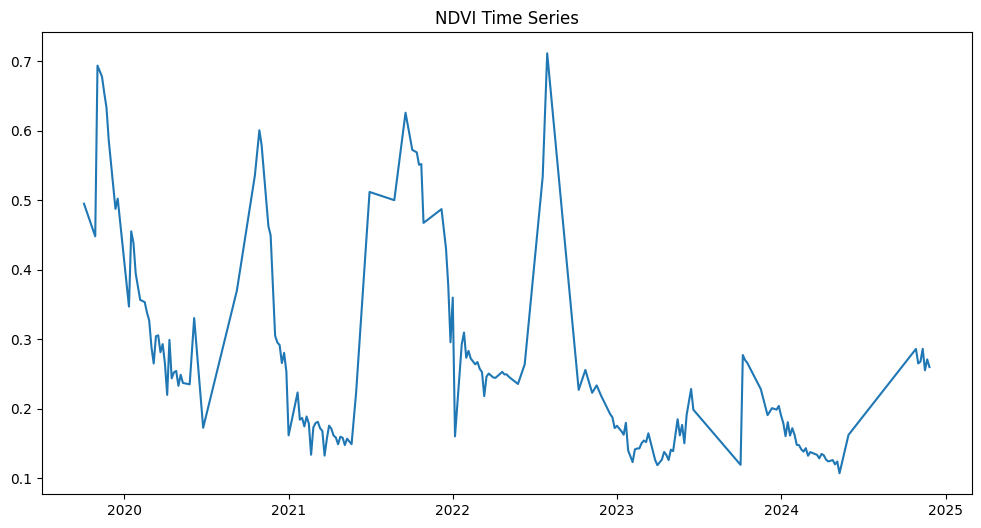

In [ ]:
 # Load data
data = loading_and_interpolation(r'/content/BheemaHostel_NDVI_TimeSeries_2019_2024.csv')

# Visualize data
plt.figure(figsize=(12,6))
plt.plot(data.index, data['NDVI'])
plt.title('NDVI Time Series')
plt.show()


In [67]:
#@title data exploration

# Function to plot the 1-month rolling average of NDVI
def plot_rolling_average(data,days):
    # Load the data
    df = data

    # Calculate the 1-month rolling average (30 days window)
    df['NDVI_rolling_avg'] = df['NDVI'].rolling(window=days).mean()

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['NDVI'], label='Original NDVI', color='blue', alpha=0.5)
    label = f'{days} Rolling Average'
    title = f'NDVI with {days} days Rolling Average'
    plt.plot(df.index, df['NDVI_rolling_avg'], label=label, color='red', linewidth=2)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.legend()
    plt.grid(True)
    plt.show()

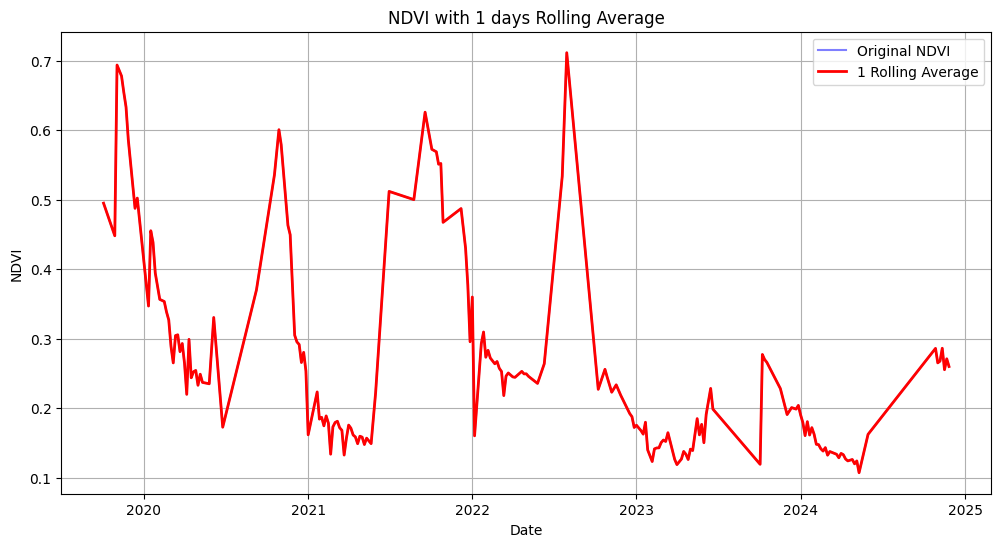

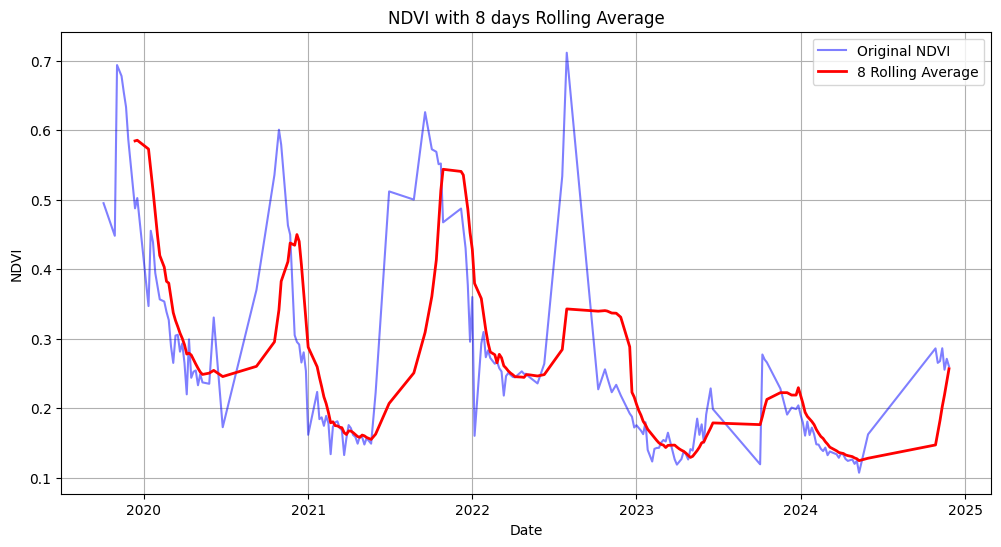

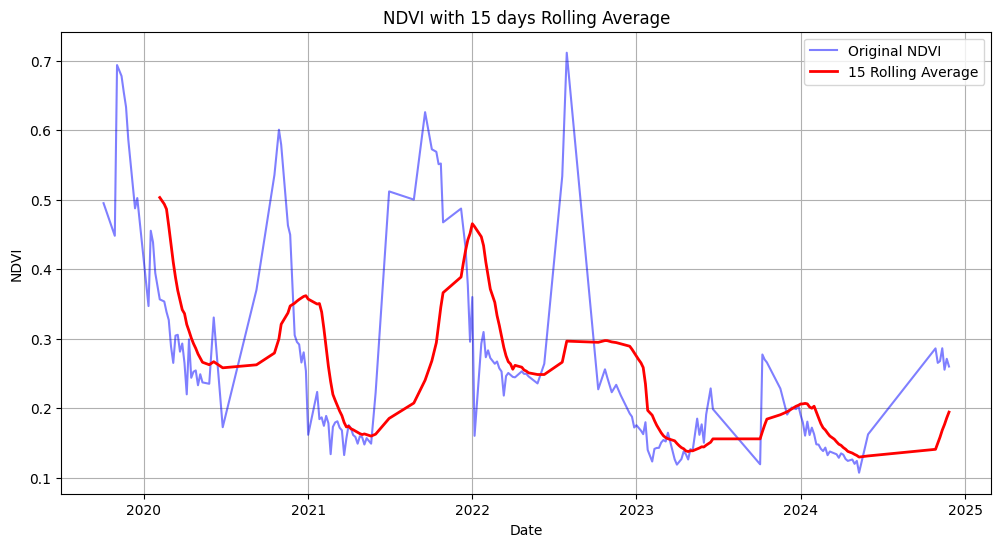

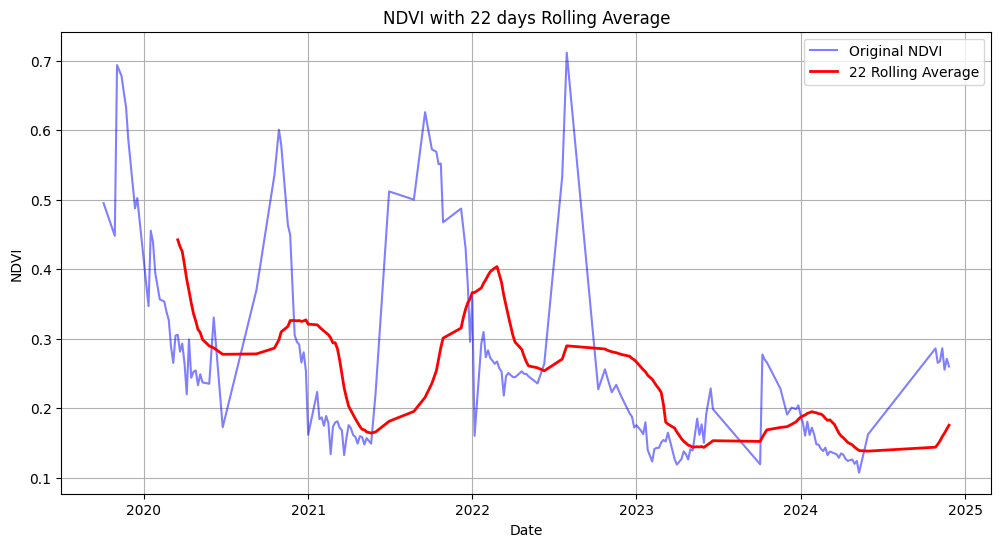

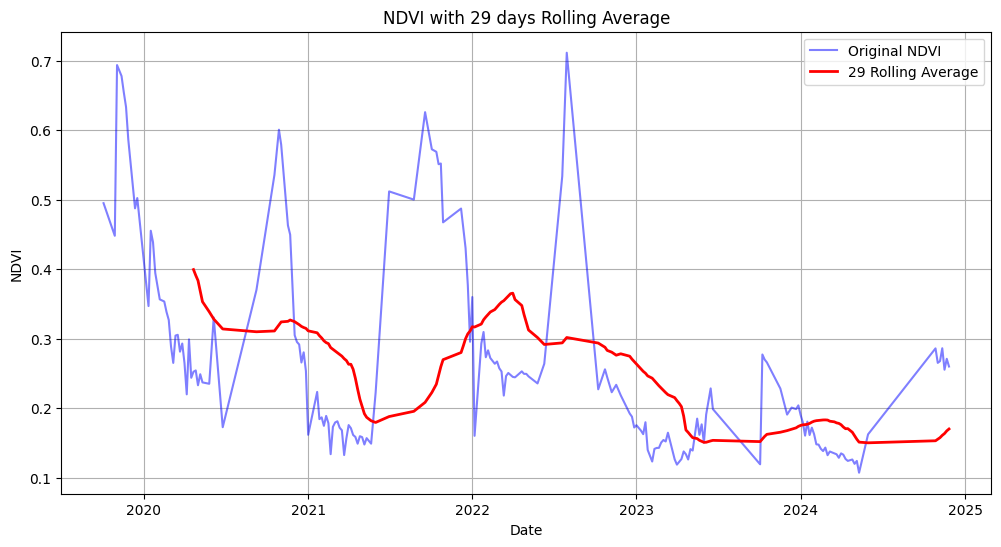

In [68]:
for i in range(1,31,7):
  plot_rolling_average(data,i)

In [ ]:
#@title data preprocessing

# Stationarity Tests
def stationarity_tests(timeseries):
    # ADF Test
    print('Augmented Dickey-Fuller Test:')
    adf_result = adfuller(timeseries)
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')

    # KPSS Test
    print('\nKPSS Test:')
    kpss_result = kpss(timeseries)
    print(f'KPSS Statistic: {kpss_result[0]}')
    print(f'p-value: {kpss_result[1]}')

    # Visualize
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    timeseries.plot(title='Original Time Series')
    plt.subplot(212)
    timeseries.diff().plot(title='Differenced Time Series')
    plt.tight_layout()
    plt.show()

# Seasonality and Autocorrelation Analysis
def seasonality_analysis(timeseries):
    # Plot ACF and PACF
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plot_acf(timeseries, ax=plt.gca())
    plt.title('Autocorrelation Function')
    plt.subplot(122)
    plot_pacf(timeseries, ax=plt.gca())
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()

# Differencing and Transformation
def transform_series(timeseries):
    # Log transformation
    log_series = np.log(timeseries)

    # First difference
    diff_series = log_series.diff().dropna()

    return log_series, diff_series


Stationarity Tests:
Augmented Dickey-Fuller Test:
ADF Statistic: -3.7836530925840925
p-value: 0.0030790639088073067
Critical Values:
	1%: -3.4648754262570978
	5%: -2.876714157488788
	10%: -2.574858699001736

KPSS Test:
KPSS Statistic: 0.8848253641926792
p-value: 0.01


<ipython-input-4-8873532c2057>:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


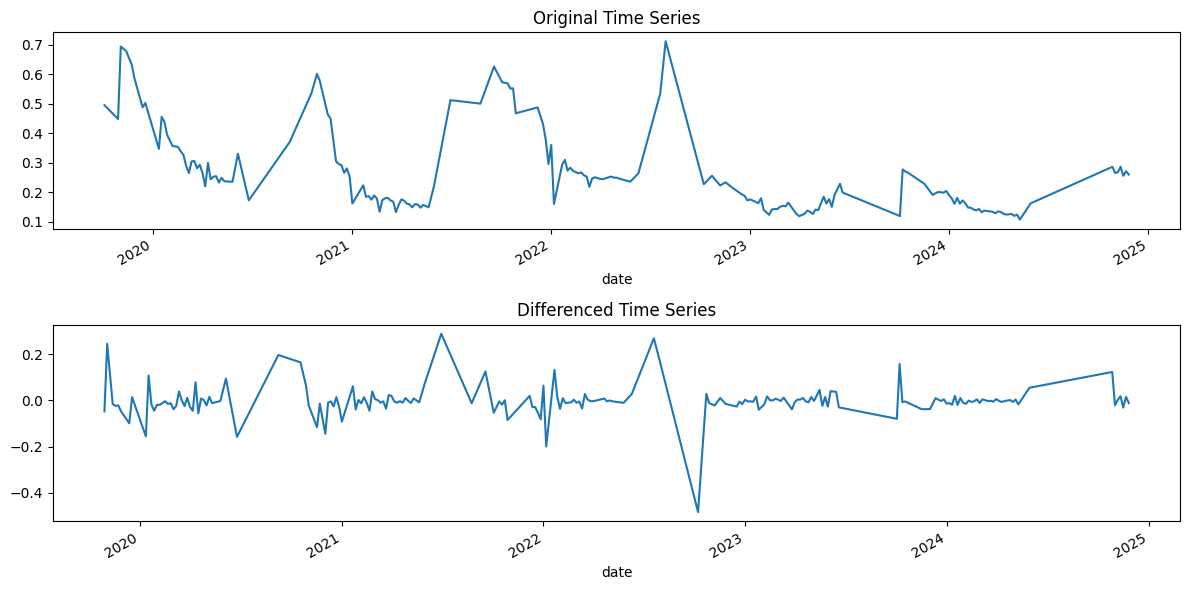

In [ ]:
# Stationarity Analysis
print("Stationarity Tests:")
stationarity_tests(data['NDVI'])


Seasonality and Autocorrelation Analysis:


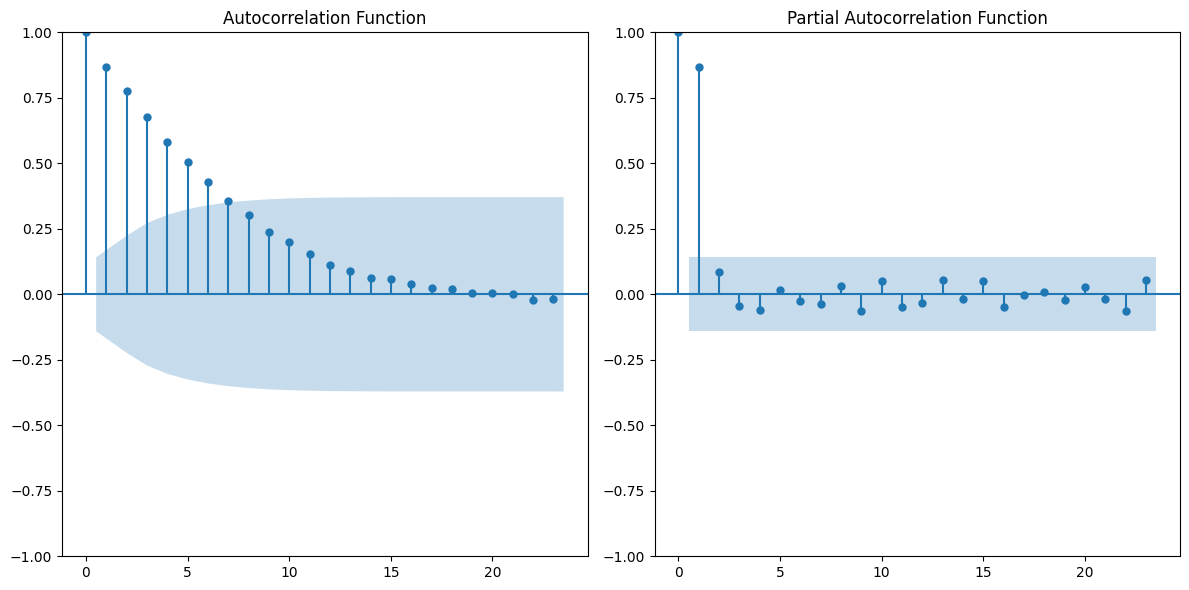

In [ ]:
# Seasonality Analysis
print("\nSeasonality and Autocorrelation Analysis:")
seasonality_analysis(data['NDVI'])


Stationarity Tests after Log Transformation and Differencing:
Augmented Dickey-Fuller Test:
ADF Statistic: -16.921222801678574
p-value: 9.936642251524128e-30
Critical Values:
	1%: -3.465058702600837
	5%: -2.8767942675230356
	10%: -2.5749014492475535

KPSS Test:
KPSS Statistic: 0.06248016822889688
p-value: 0.1


<ipython-input-4-8873532c2057>:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries)


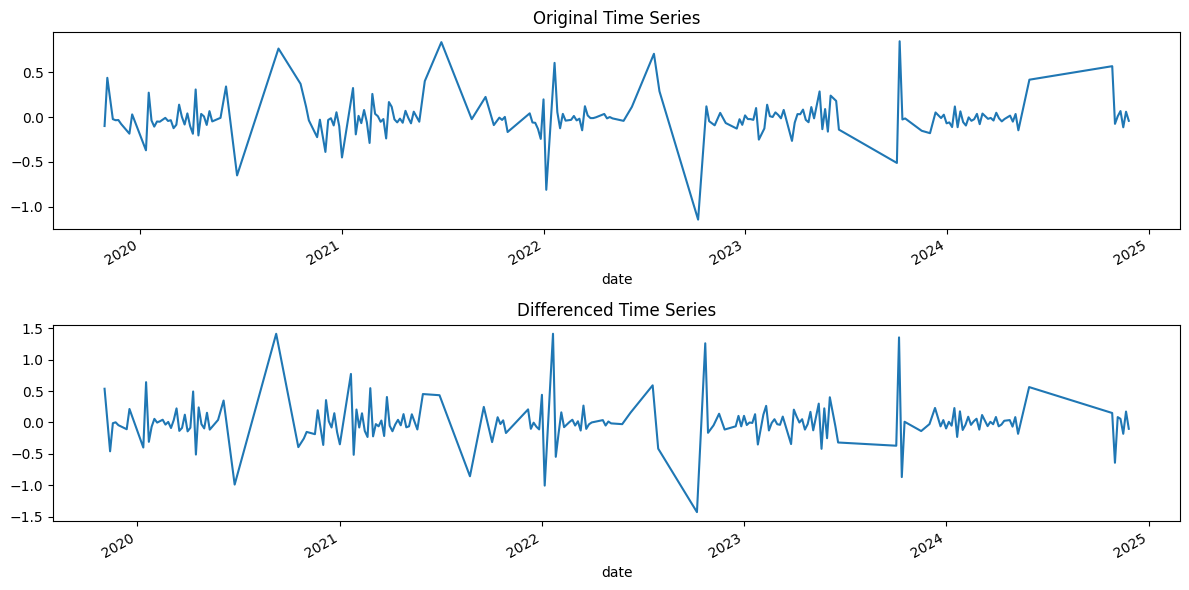

In [ ]:
# Log and Differenced Series
log_series, diff_series = transform_series(data['NDVI'])
# Repeating Stationarity Tests on Transformed Data
print("\nStationarity Tests after Log Transformation and Differencing:")
stationarity_tests(diff_series)

In [ ]:
#@title ARIMA Forecasting
def arima_forecast(timeseries, forecast_steps=10):
    # Auto ARIMA for best model selection
    auto_model = pm.auto_arima(
        timeseries,
        seasonal=True,
        m=12,  #seasonality
        suppress_warnings=True,
        stepwise=True
    )

    # Fit the model
    model = auto_model

    # Forecast
    forecast, conf_int = model.predict(
        n_periods=forecast_steps,
        return_conf_int=True
    )

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(timeseries.index, timeseries, label='Original')
    forecast_index = pd.date_range(
        start=timeseries.index[-1],
        periods=forecast_steps+1,
        freq='M'
    )[1:]
    plt.plot(forecast_index, forecast, color='red', label='Forecast')
    plt.fill_between(
        forecast_index,
        conf_int[:, 0],
        conf_int[:, 1],
        color='pink',
        alpha=0.3
    )
    plt.title('ARIMA Forecast')
    plt.legend()
    plt.show()

    return model, forecast, conf_int


ARIMA Forecasting:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-33-7d0791a2303b>:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(


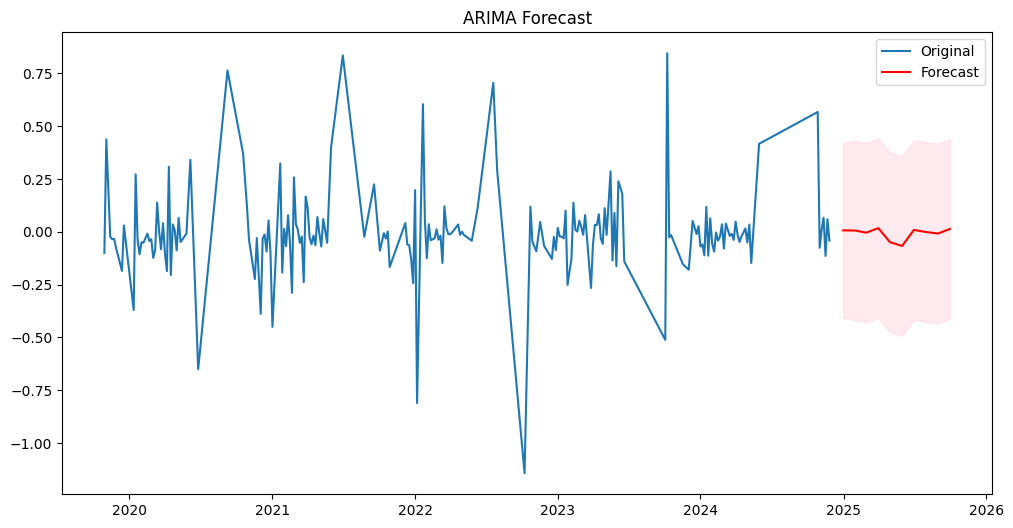

In [61]:
# ARIMA Forecasting
print("\nARIMA Forecasting:")
steps = 10
arima_model, arima_forecast_vals, conf_int = arima_forecast(diff_series, steps)

In [84]:
#@title LSTM Forecasting
def prepare_lstm_data(data, look_back=50):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    # Create dataset for LSTM
    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:i+look_back])
        y.append(scaled_data[i+look_back])

    return np.array(X), np.array(y), scaler

def create_lstm_model(look_back=12):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        tf.keras.layers.LSTM(50, activation='relu'),
        tf.keras.layers.Dense(25, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [92]:
def lstm_forecast(data, look_back=50, forecast_steps=50):
    # Prepare data
    X, y, scaler = prepare_lstm_data(data, look_back)

    # Reshape for LSTM
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Split data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Create and train model
    model = create_lstm_model(look_back)
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Forecasting
    last_sequence = X_test[-1]
    forecasted = []

    for _ in range(forecast_steps):
        # Predict next value
        next_pred = model.predict(last_sequence.reshape(1, look_back, 1))
        forecasted.append(next_pred[0][0])

        # Update sequence
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = next_pred

    # Inverse transform
    forecasted = scaler.inverse_transform(np.array(forecasted).reshape(-1, 1))

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data, label='Original')
    forecast_index = pd.date_range(
        start=data.index[-1],
        periods=forecast_steps+1,
        freq='M'
    )[1:]
    plt.plot(forecast_index, forecasted, color='red', label='LSTM Forecast')
    plt.title('LSTM Forecast')
    plt.legend()
    plt.show()

    return forecasted


LSTM Forecasting:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<ipython-input-86-f44b61d389ff>:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(


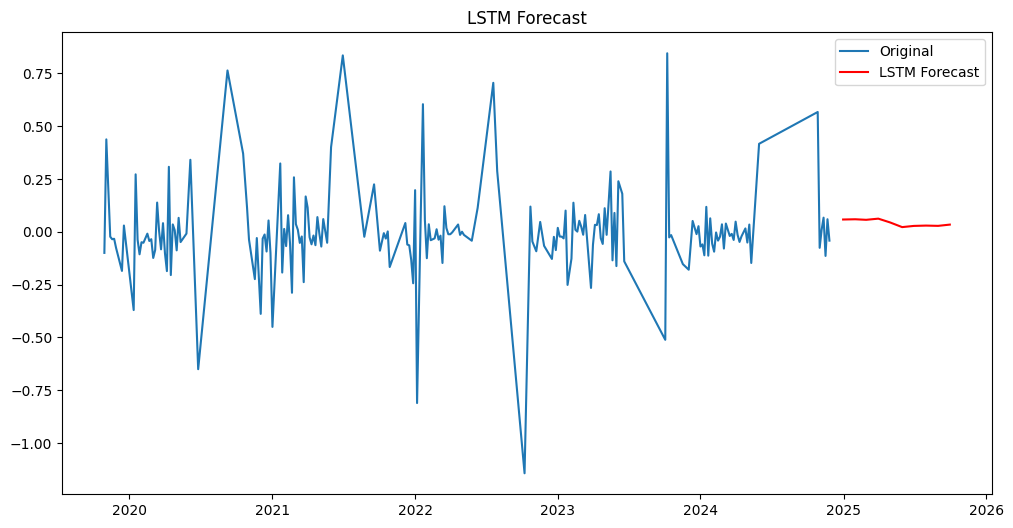

In [87]:
# LSTM Forecasting
print("\nLSTM Forecasting:")
steps = 10
lstm_forecast_vals = lstm_forecast(diff_series,steps)


ARIMA Forecasting:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-33-7d0791a2303b>:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(


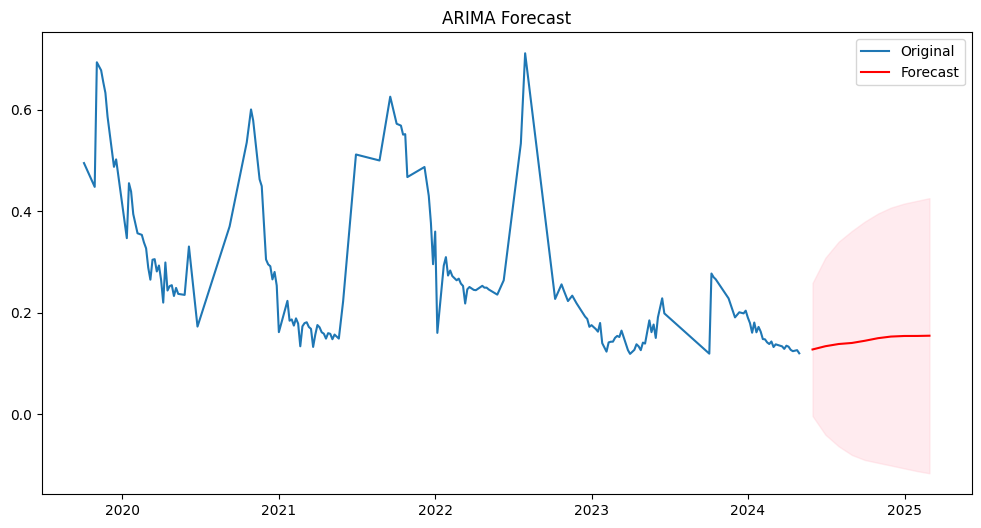


LSTM Forecasting:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


<ipython-input-86-f44b61d389ff>:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(


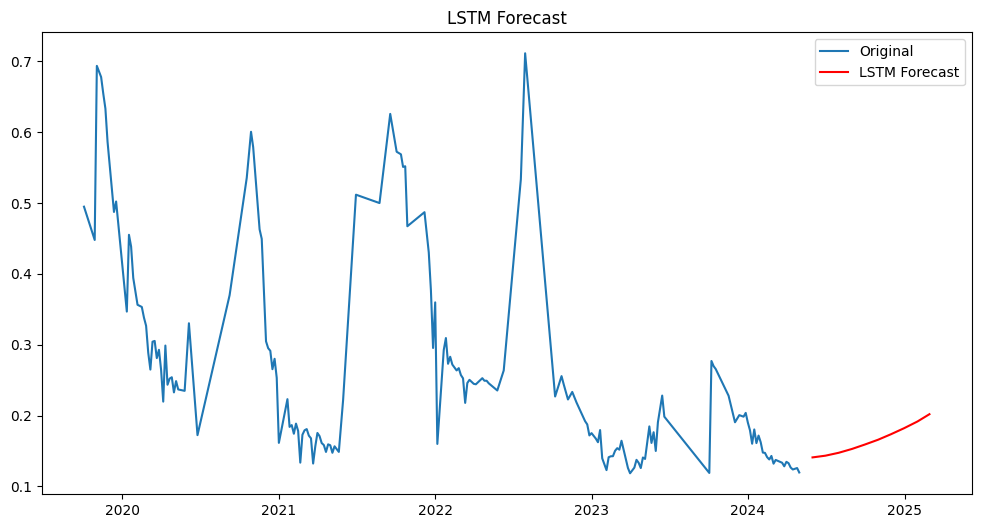

In [91]:
#@title Comparision

# Split the data into training and testing sets
steps = 50
train_data = data['NDVI'][:-steps]  # All data except the last 10 steps for training
test_data = data['NDVI'][-steps:]  # The last 10 steps for testing

# ARIMA Forecasting
print("\nARIMA Forecasting:")
arima_model, arima_forecast_vals, conf_int = arima_forecast(train_data, steps)

# LSTM Forecasting
print("\nLSTM Forecasting:")
lstm_forecast_vals = lstm_forecast(train_data, steps)

# Now, let's plot the comparison of original data with forecasts
forecast_dates = pd.date_range(start=data.index[-steps], periods=steps, freq='D')  # Generate forecast dates

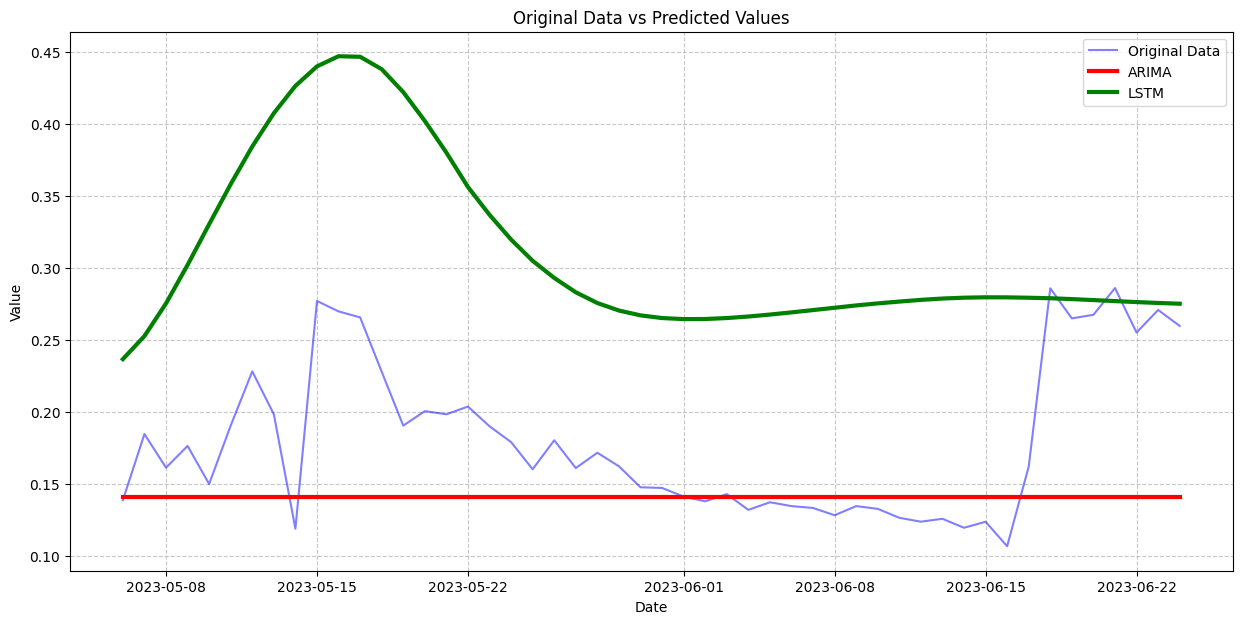

In [108]:
dates = forecast_dates
original_data = data['NDVI']

# Function to plot comparison of original data with subset
def plot_data_comparison(original_series, subset_series1 ,subset_series2,dates):
    """
    Plot original data and its subset with different colors.

    Parameters:
    - original_series: Full original pandas Series
    - subset_series: Subset of the original series
    """
    plt.figure(figsize=(15, 7))

    subset_original_series = original_series.iloc[len(original_series)-len(subset_series1):]
    original_series = pd.Series(np.ravel(subset_original_series), index=dates)  # Flatten the original series
    subset_series1 = pd.Series(np.ravel(subset_series1), index=dates)  # Flatten the ARIMA forecast
    subset_series2 = pd.Series(np.ravel(subset_series2), index=dates)  # Flatten the LSTM forecast

    # Plot full original data in blue
    plt.plot(original_series.index, original_series.values,
             label='Original Data', color='blue', alpha=0.5)

    # Plot subset in red
    plt.plot(subset_series1.index, subset_series1.values,
             label='ARIMA', color='red', linewidth=3)

    # Plot subset in red
    plt.plot(subset_series1.index, subset_series2.values,
             label='LSTM', color='green', linewidth=3)

    plt.title('Original Data vs Predicted Values')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.show()


# Plot comparison
plot_data_comparison(original_data, arima_forecast_vals, lstm_forecast_vals,dates)

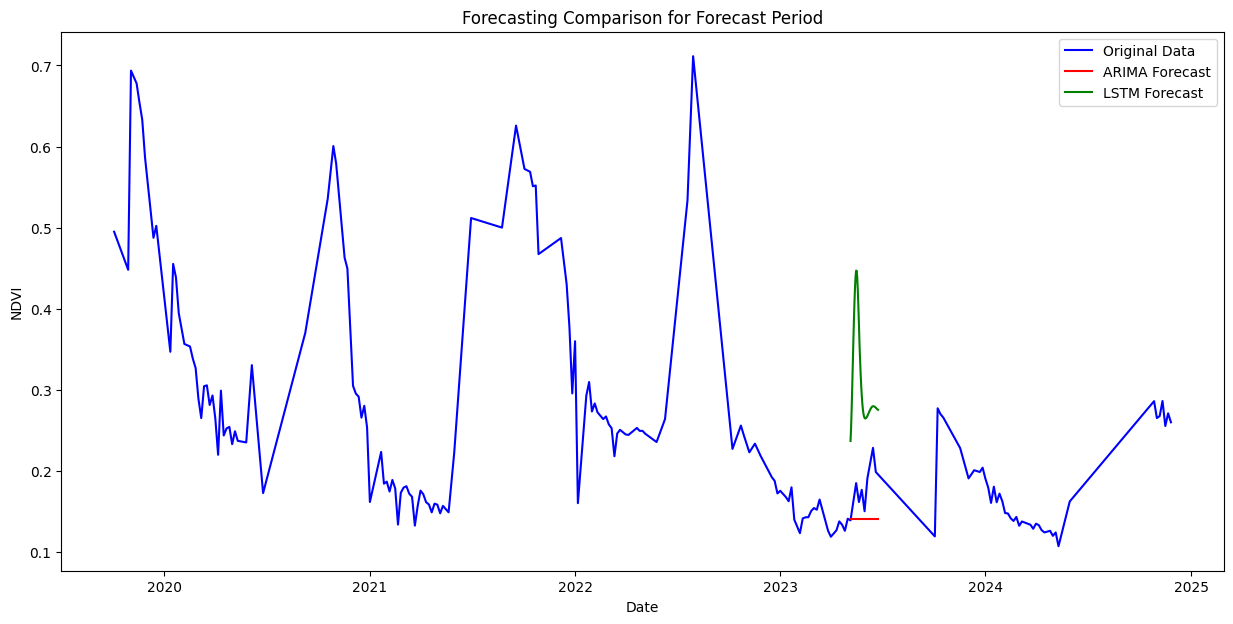

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to plot the comparison of original vs forecasts, including the original as a blue line
def plot_comparison(original, arima_forecast, lstm_forecast, forecast_dates):
    # Convert forecast values to pandas Series and assign dates as index
    arima_forecast_series = pd.Series(np.ravel(arima_forecast), index=forecast_dates)  # Flatten the ARIMA forecast
    lstm_forecast_series = pd.Series(np.ravel(lstm_forecast), index=forecast_dates)  # Flatten the LSTM forecast

    # Create an index for the entire range, including the original data plus forecast_dates
    full_index = original.index.append(forecast_dates)

    # Combine the original data and forecast data into a single Series for plotting
    full_ndvi = pd.concat([original, pd.Series(np.ravel([np.nan] * len(forecast_dates)), index=forecast_dates)], axis=0)

    # Plot the forecasts and the original data
    plt.figure(figsize=(15, 7))

    # Plot the original data (NDVI values) up to the last original data point
    plt.plot(original.index, original.values, label='Original Data', color='blue')

    # Plot the forecasted ARIMA and LSTM values for the forecast period
    plt.plot(arima_forecast_series.index, arima_forecast_series, label='ARIMA Forecast', color='red')
    plt.plot(lstm_forecast_series.index, lstm_forecast_series, label='LSTM Forecast', color='green')

    # Add title and labels
    plt.title('Forecasting Comparison for Forecast Period')
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.legend()

    # Show the plot
    plt.show()

# Ensure forecast_dates are correct
forecast_dates = pd.date_range(start=data.index[-steps], periods=steps, freq='D')  # Generate forecast dates

# Plotting the comparison for forecast dates
plot_comparison(data['NDVI'], arima_forecast_vals, lstm_forecast_vals, forecast_dates)


Stationarity Tests:
Augmented Dickey-Fuller Test:
ADF Statistic: -3.7836530925840925
p-value: 0.0030790639088073067
Critical Values:
	1%: -3.4648754262570978
	5%: -2.876714157488788
	10%: -2.574858699001736

KPSS Test:
KPSS Statistic: 0.8848253641926792
p-value: 0.01


<ipython-input-4-8873532c2057>:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


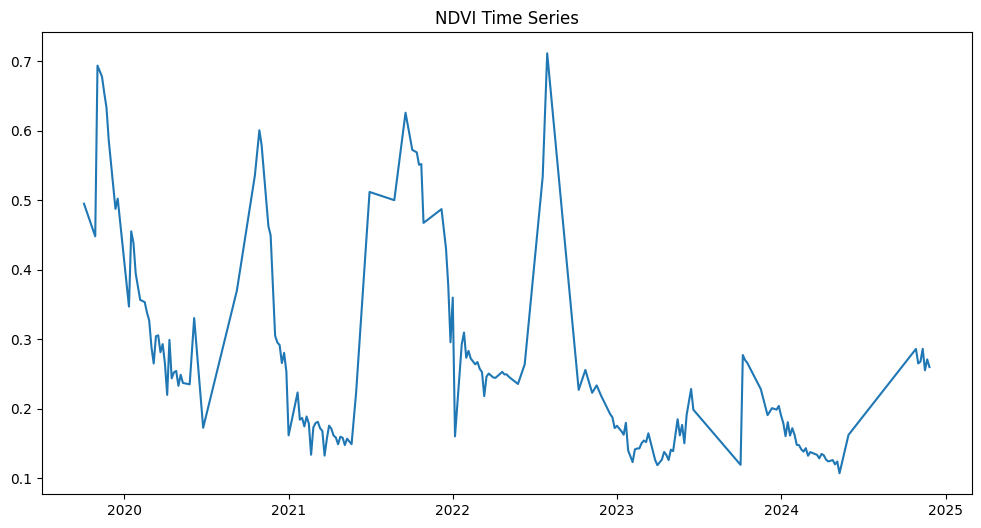

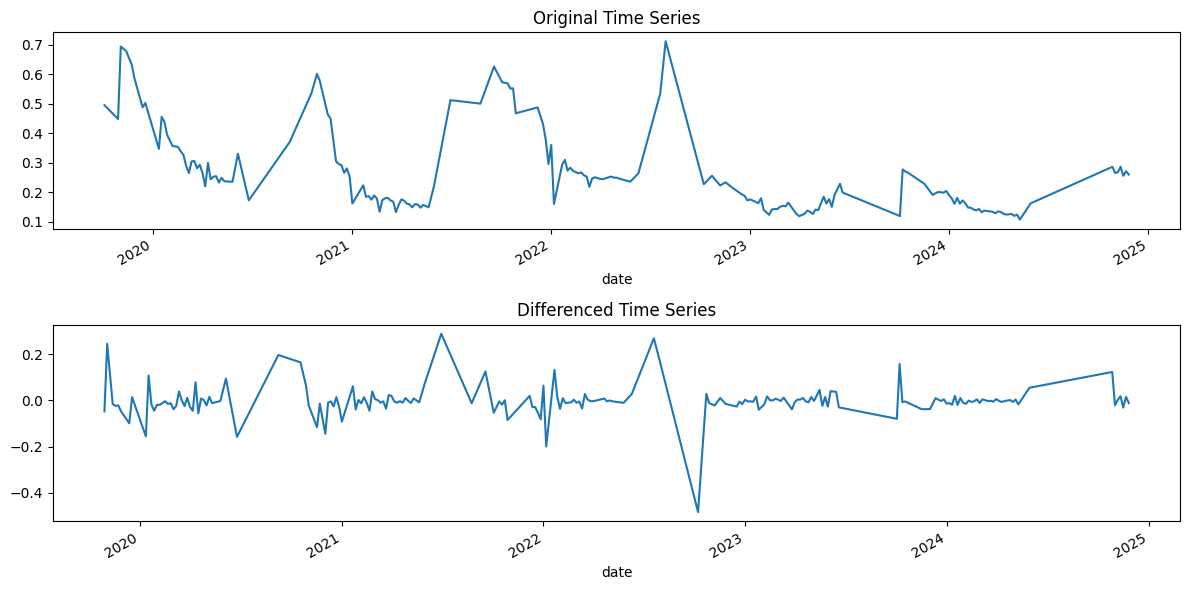


Seasonality and Autocorrelation Analysis:


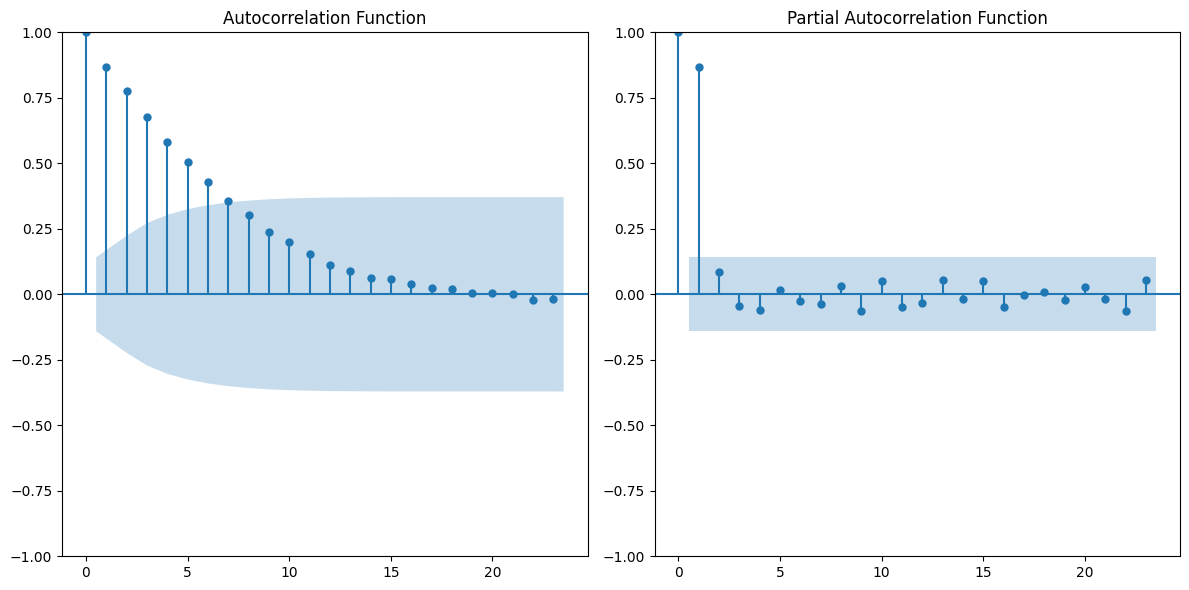


Stationarity Tests after Log Transformation and Differencing:
Augmented Dickey-Fuller Test:
ADF Statistic: -16.921222801678574
p-value: 9.936642251524128e-30
Critical Values:
	1%: -3.465058702600837
	5%: -2.8767942675230356
	10%: -2.5749014492475535

KPSS Test:
KPSS Statistic: 0.06248016822889688
p-value: 0.1


<ipython-input-4-8873532c2057>:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries)


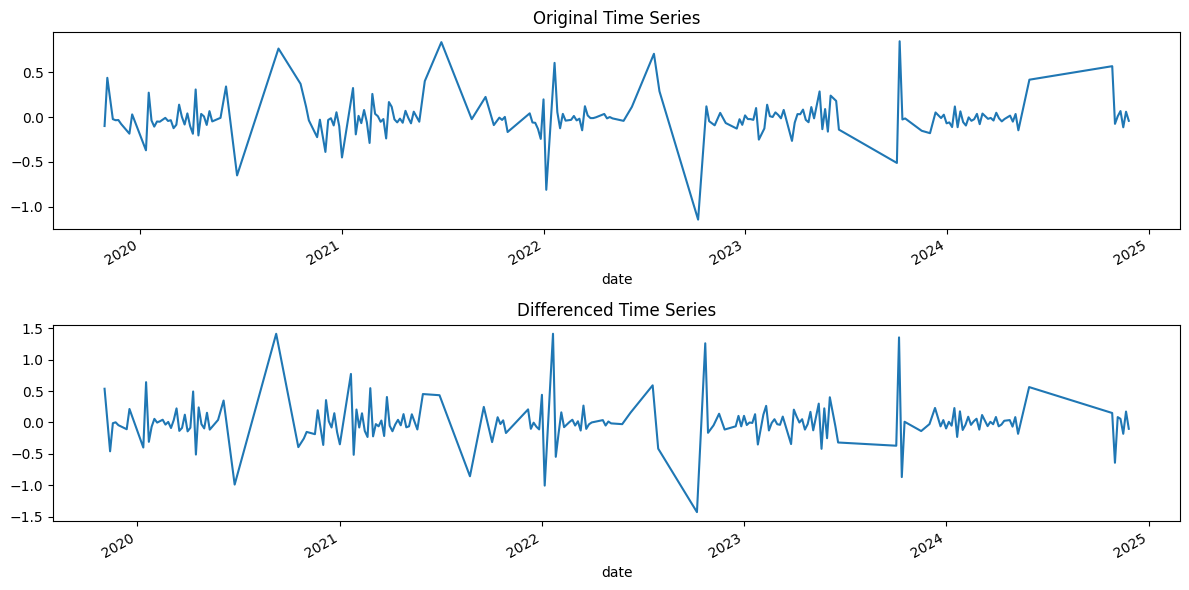


ARIMA Forecasting:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-33-7d0791a2303b>:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(


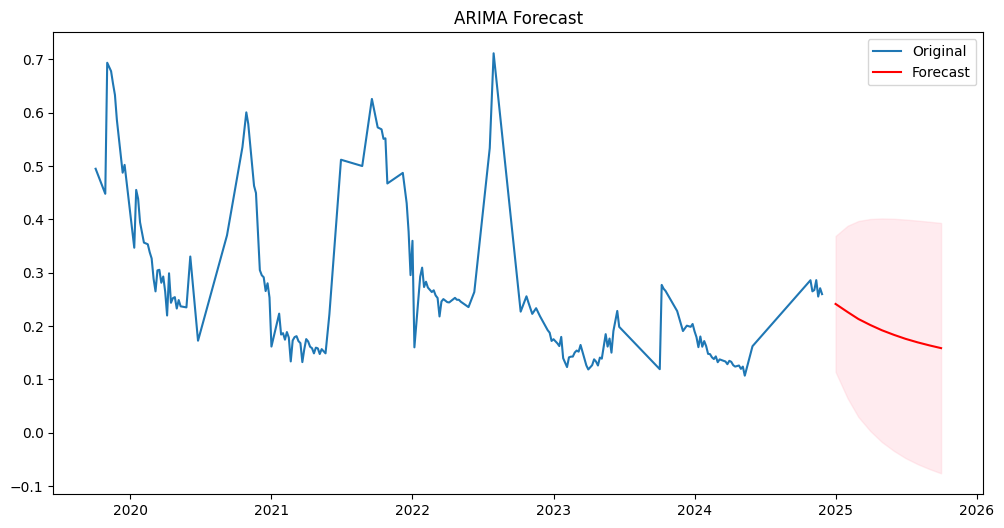


LSTM Forecasting:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

<ipython-input-92-b8f0a936031e>:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(


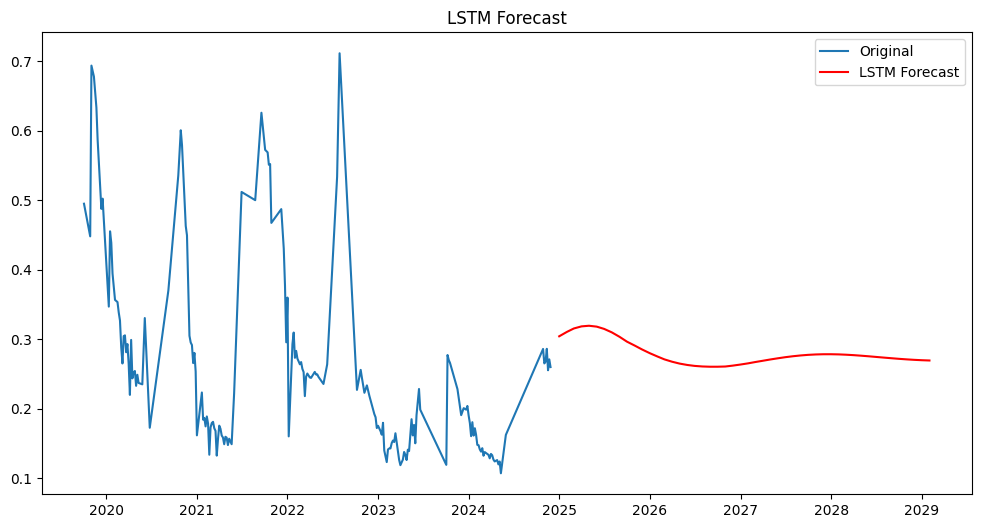

In [98]:
#@title Main Execution

def main():
    # Load data
    data = loading_and_interpolation(r'/content/BheemaHostel_NDVI_TimeSeries_2019_2024.csv')

    # Visualize data
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data['NDVI'])
    plt.title('NDVI Time Series')

    # Stationarity Analysis
    print("Stationarity Tests:")
    stationarity_tests(data['NDVI'])

    # Seasonality Analysis
    print("\nSeasonality and Autocorrelation Analysis:")
    seasonality_analysis(data['NDVI'])

    # Log and Differenced Series
    log_series, diff_series = transform_series(data['NDVI'])

    # Repeat Stationarity Tests on Transformed Data
    print("\nStationarity Tests after Log Transformation and Differencing:")
    stationarity_tests(diff_series)

    # ARIMA Forecasting
    print("\nARIMA Forecasting:")
    arima_model, arima_forecast_vals, conf_int = arima_forecast(data['NDVI'])

    # LSTM Forecasting
    print("\nLSTM Forecasting:")
    lstm_forecast_vals = lstm_forecast(data['NDVI'])


# Run the analysis
if __name__ == '__main__':
    main()